In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
import cmdstanpy
import pandas as pd
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

from plots import plot_posterior_time_series
from measurements import form_table, display_measurements
from distributions import plot_invgammas
import samples

# matplotlib.style.use('seaborn-poster')
matplotlib.style.use('ggplot')

## Population info

In [2]:
# worldometer.com, just took the current ones.  these numbers can be pretty approximate.
populations = {
    'Italy':60488135,
    'China':1435000000,
    'Korea, South':51256309,
    'Spain':46749498,
    'US':331002651,
    'Australia':25411689,
    'Iran':83671720,
    'France':65231249,
    'Germany':83706861,
    'India':1376085273,
    'Russia':145916728,
}

# Running simulations

The first step is to simulate a bunch of measurements to ensure our model is doing roughly what we expect.

In [3]:
sim_config = {
    'start_index':0,
    'start_at_infections':50,
    'start_at_deaths':5,
    'country':'Australia',
    'model_name':'sird_reduced_simulate.stan',
}

sim_day_count = 52
sim_y0 = np.array([sim_config['start_at_infections'], 11, sim_config['start_at_deaths']])
sim_data = {
    # These initial conditions can be drawn from actual data as desired
    'y0':sim_y0,
    'T':sim_day_count,
    'ts':list(range(0, sim_day_count)),
    'population':populations[sim_config['country']],
    'sigma_infected':0.3,
    'sigma_dead':0.1,
    'beta':0.12,
    'gamma':0.004,
    'zeta':0.001,
}

In [4]:
sim_model = cmdstanpy.CmdStanModel(stan_file=sim_config['model_name'])

sim_results = sim_model.sample(data=sim_data,
                       # show_progress='notebook',
                       # Use a fixed seed so that our runs are deterministic.
                       seed=2222,
                       # This computer has 24 cores/48 threads; 24 chains is plenty
                       cores=24,
                       chains=24,
                       # Make sure to get enough samples to avoid any diagnostic problems
                       iter_sampling=300,
                       fixed_param=True)

# Generate a run summary
_ = samples.run_validate_stan(sim_results, ())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced_simulate
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:start chain 7
INFO:cmdstanpy:start chain 8
INFO:cmdstanpy:start chain 9
INFO:cmdstanpy:start chain 10
INFO:cmdstanpy:start chain 11
INFO:cmdstanpy:start chain 12
INFO:cmdstanpy:start chain 13
INFO:cmdstanpy:start chain 14
INFO:cmdstanpy:start chain 15
INFO:cmdstanpy:start chain 16
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 17
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 18
INFO:cmdstanpy:start chain 19
INFO:cmdstanpy:start chain 20
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 21
INFO:cmdstanpy:start chain 22
INFO:cmdstanpy:start chain 23
INFO:cmdstanpy:start chain 24
INFO:cmdstanpy:

This plot shows the simulated noisy measurements.

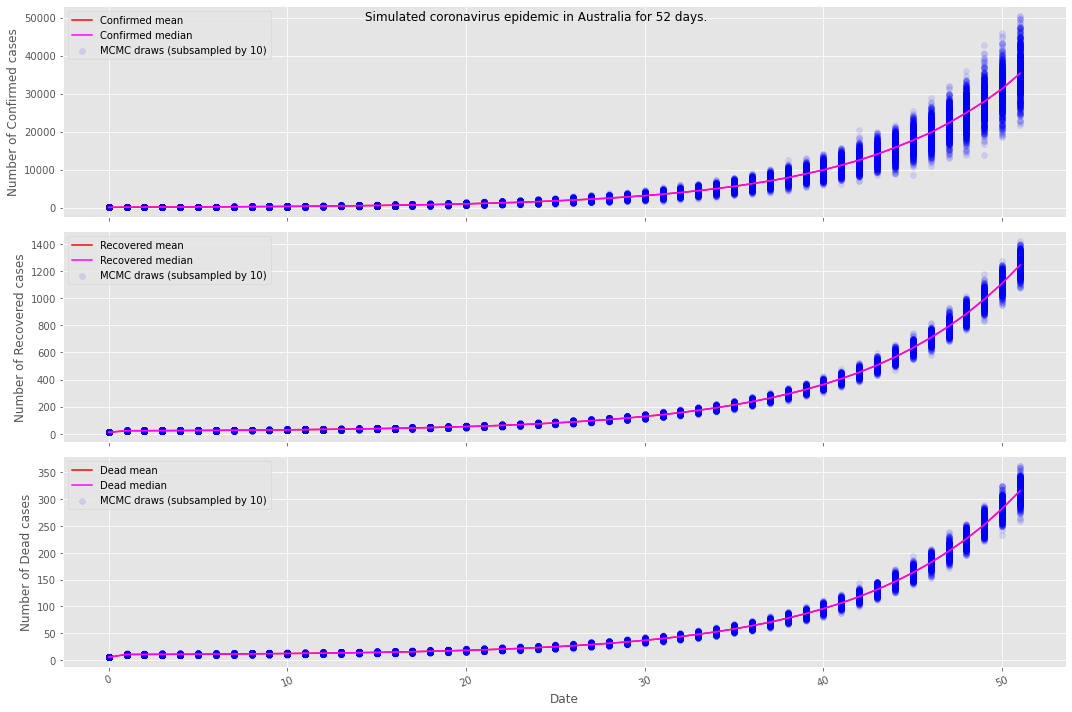

In [5]:
sim_samples = samples.get_sample_time_series(sim_results)
plot_posterior_time_series(sim_samples, None, sim_config, sample_points_only=True)

# Visualizing the prior

I heard that the prior can only be understood in the context of the likelihood.  Let's try to understand our prior.

It's handy to be able to visualize a few distributions when assigning priors.

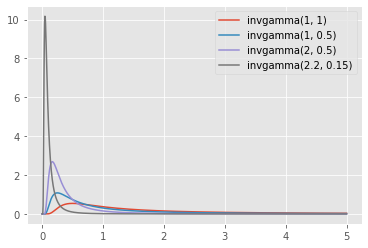

In [6]:
plot_invgammas([(1, 1), (1, 0.5), (2, 0.5), (2.2, 0.15)])

In [144]:
prior_data = {
    ## Parameters
    'y':sim_samples[0, :, :].transpose(),
    'T':sim_day_count,
    'ts':list(range(0, sim_day_count)),
    'population':populations[sim_config['country']],
    # inverse gamma
    'sigma_infected_prior':[3, 0.1],
    # inverse gamma
    'sigma_dead_prior':[3, 0.1],
    # inverse gamma
    'beta_prior':[3.0, 0.8],
    # normal
    'gamma_prior':[0, 0.2],
    # normal
    'zeta_prior':[0, 0.2],
}

# We want to examine a run summary and look at posteriors and so on for these parameters
important_values = (
    'lp__',
    'beta',
    'gamma',
    'zeta',
    'sigma_infected',
    'sigma_dead',
) 

# We can't look for 'lp__' in the posterior stuff
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))

See the comments about how to run the sampler.  We always generate a run summary every time we run this cell.  Its results should always be examined before proceeding to any other analysis.

In [145]:
prior_model = cmdstanpy.CmdStanModel(stan_file='sird_reduced_prior.stan')

prior_fit = prior_model.sample(data=prior_data,
                         show_progress='notebook',
                         # Use a fixed seed so that our runs are deterministic.
                         seed=2222,
                         # This computer has 24 cores/48 threads; 24 chains is plenty
                         cores=24,
                         chains=24,
                         # Make the sampler a bit more robust in exchange for more sampling time
                         adapt_delta=0.9,
                         # Let the sampler explore deeper
                         # max_treedepth=12,
                         # Make sure to get enough samples to avoid any diagnostic problems
                         iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(prior_fit, important_values)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced_prior


INFO:cmdstanpy:Processing csv files: /tmp/tmpweompsv9/sird_reduced_prior-202003231329-1-jqxi_v2b.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-2-0bekpk9m.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-3-p9hok1v_.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-4-94w94m4u.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-5-7w1eexrx.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-6-bfkt52m0.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-7-njwxi74q.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-8-ktol_jls.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-9-zaqay72h.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-10-t8rhq360.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-11-hi9ttx4m.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-12-u7zl9zo5.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-13-fcnwivzb.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329-14-odi011r7.csv, /tmp/tmpweompsv9/sird_reduced_prior-202003231329

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,8.333350,0.038475,1.720740,5.096530,8.640730,10.479500,2000.21,1318.38,1.00910
beta,0.385325,0.006213,0.333903,0.127832,0.290475,0.947959,2888.53,1903.88,1.00249
gamma,0.157075,0.001644,0.121065,0.013040,0.130022,0.386906,5421.66,3573.52,1.00216
zeta,0.161324,0.001554,0.118018,0.013577,0.138003,0.385100,5768.95,3802.42,1.00160
sigma_infected,0.050958,0.000793,0.046536,0.016038,0.038026,0.125684,3441.79,2268.54,1.00152
sigma_dead,0.048971,0.000672,0.040285,0.015959,0.037180,0.119551,3596.02,2370.20,1.00334


## Prior visualization and analysis

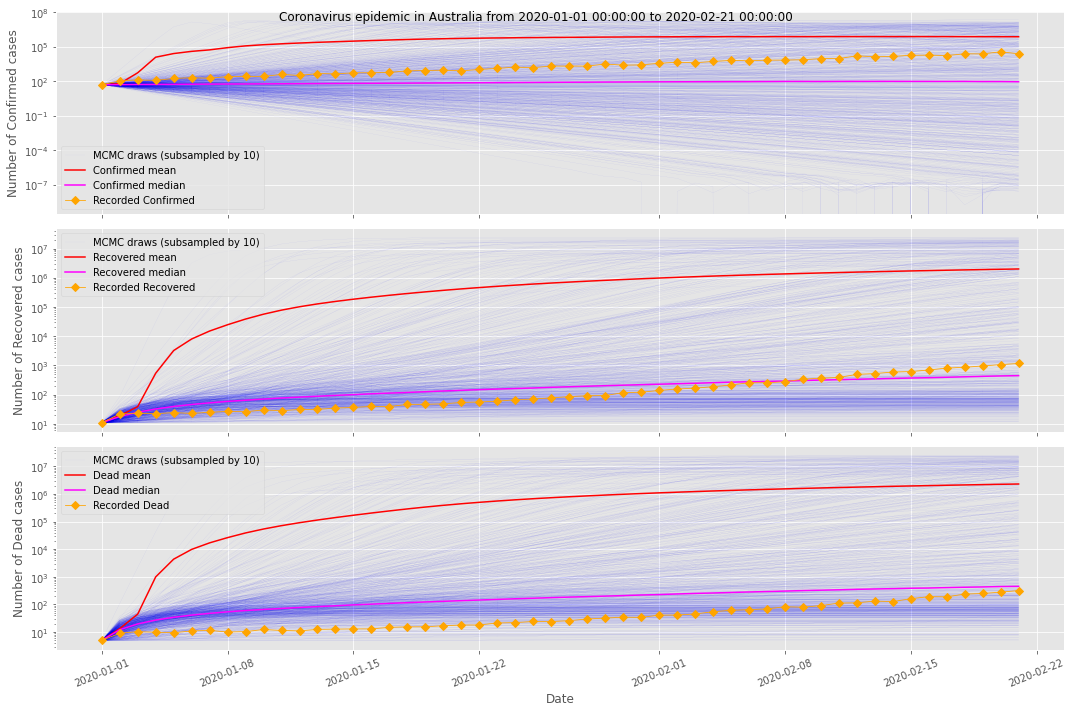

-4.3067074752334374e+29 0


In [146]:
prior_samples = samples.get_sample_time_series(prior_fit)
sim_comparison = pd.DataFrame(sim_samples[0, :, :].transpose(), 
                              index=pd.date_range(start='1/1/20', periods=sim_day_count),
                              columns=['Confirmed', 'Recovered', 'Dead'])
plot_posterior_time_series(prior_samples, sim_comparison, sim_config, plot_log=True)
log_likelihoods = samples.compute_sample_log_likelihood(prior_fit)
print(np.mean(log_likelihoods), np.count_nonzero(np.isnan(log_likelihoods)))

#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

In [147]:
inferred = az.from_cmdstanpy(prior_fit, 
                             log_likelihood='log_likelihood',
                             posterior_predictive='y_hat',
                             observed_data={'y':sim_comparison.to_numpy()})

# TODO(MP): how do you plot log probability of the sample?  'lp__' is gone.
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))

### Posterior correlation plots

/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


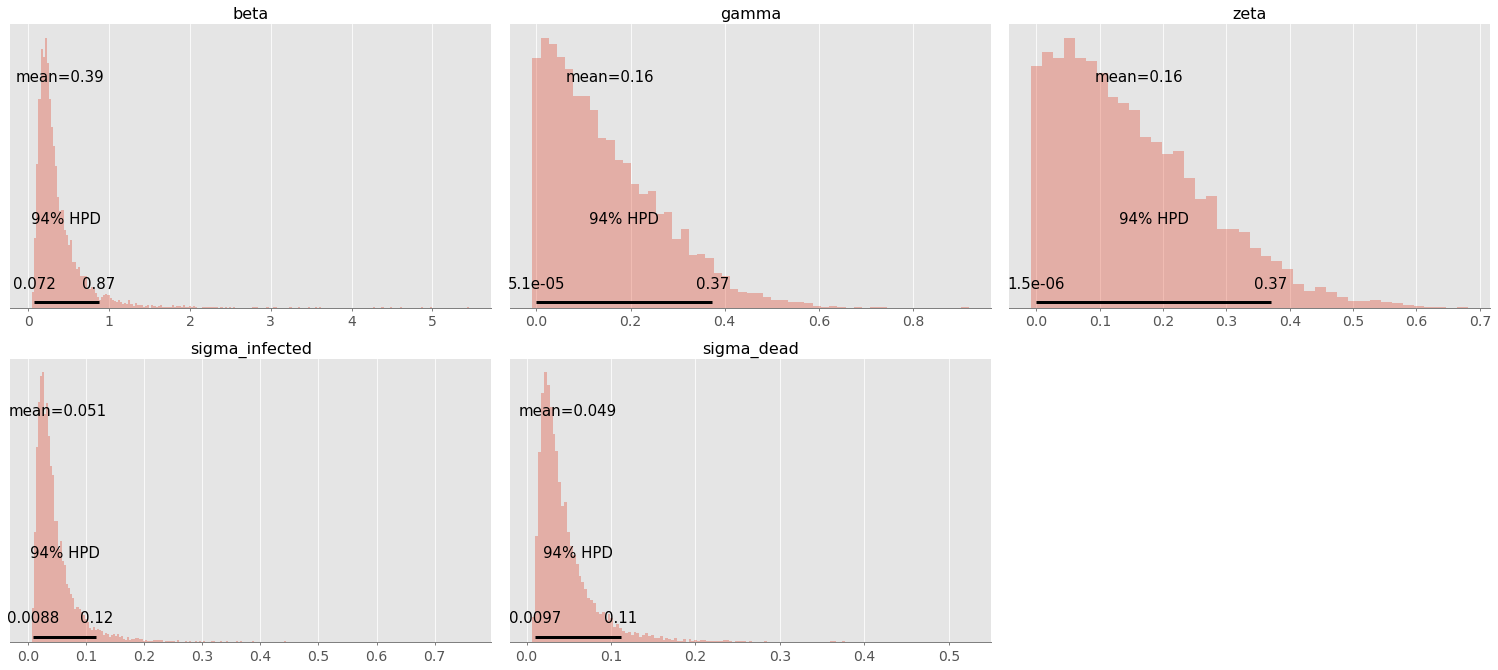

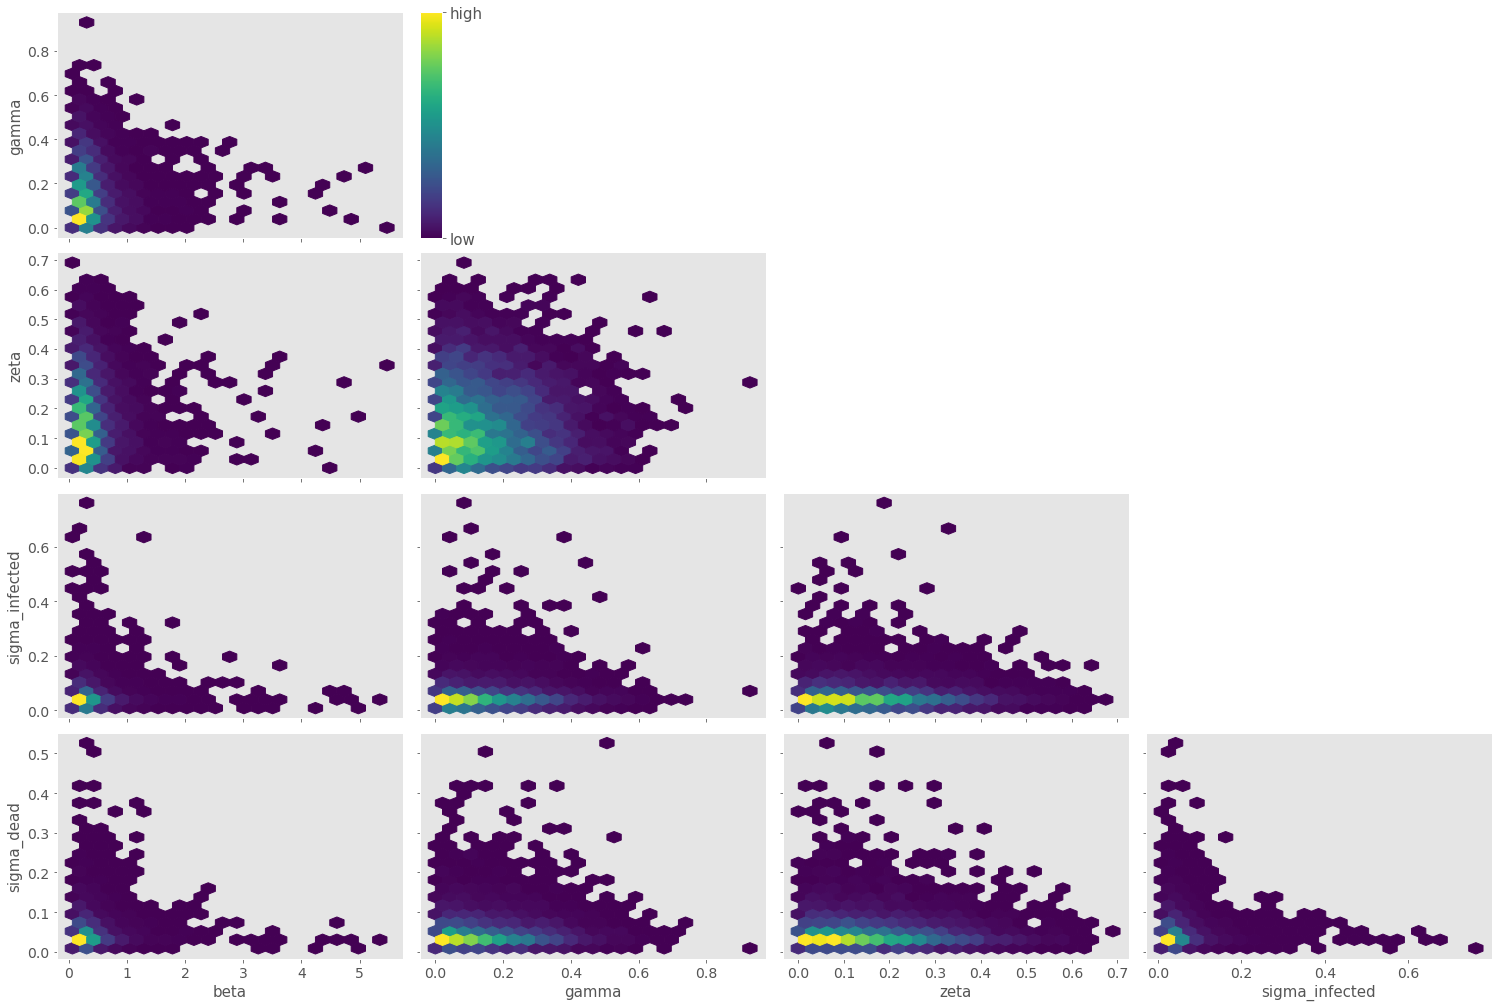

In [148]:
samples.param_posterior_arviz_plots(inferred, analysis_variables)

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:531: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO analysis:
 Computed from 7200 by 156 log-likelihood matrix

         Estimate       SE
elpd_loo -128490225224069515712608251936768.00  127140527318810484148035653730304.00
p_loo    128490225224069515712608251936768.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        3    1.9%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  153   98.1%



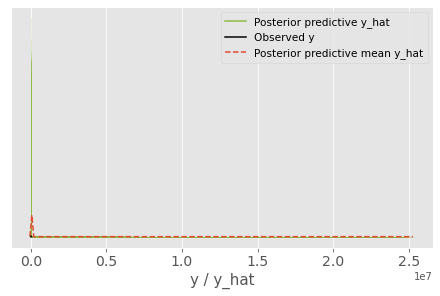

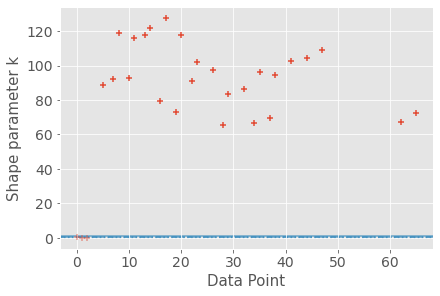

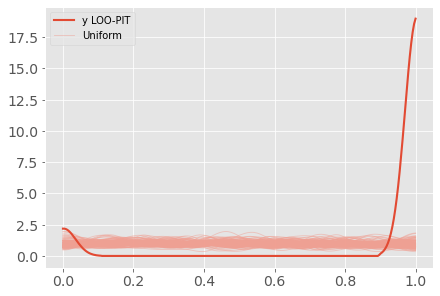

In [149]:
_ = samples.run_validate_arviz(inferred)

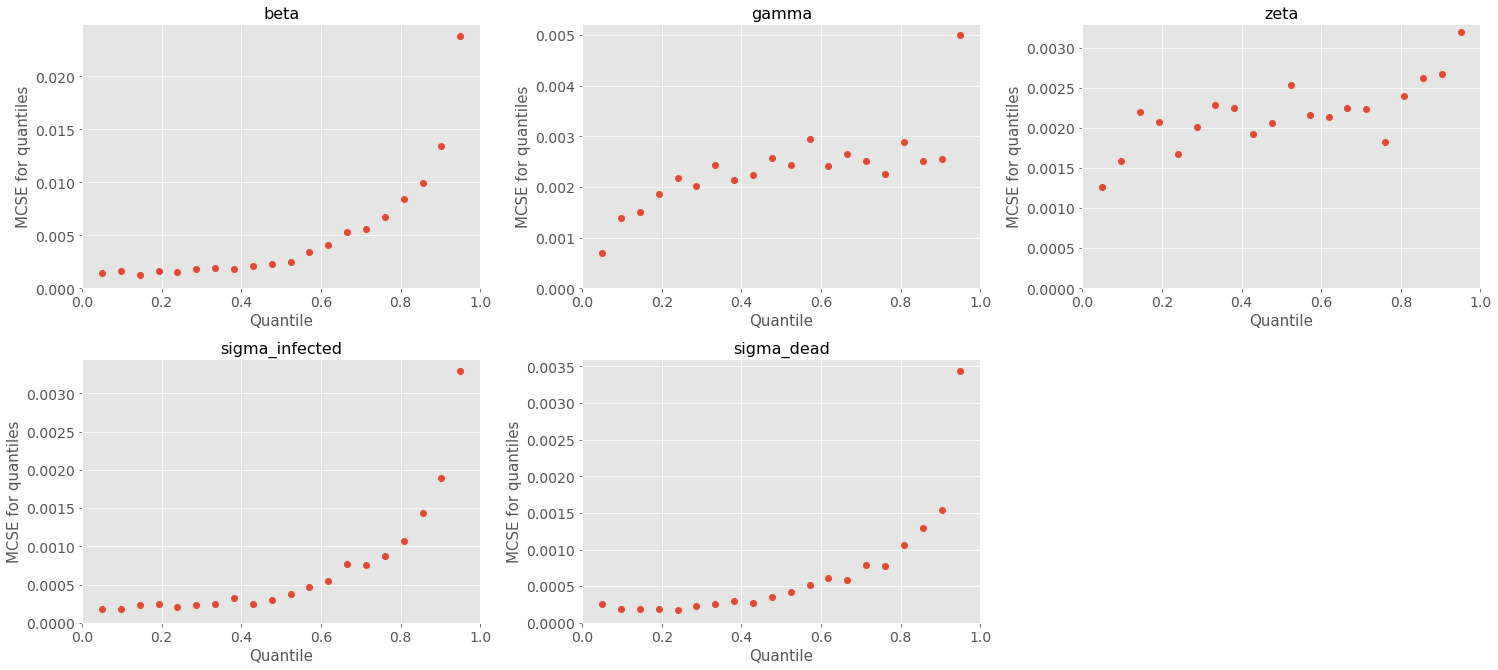

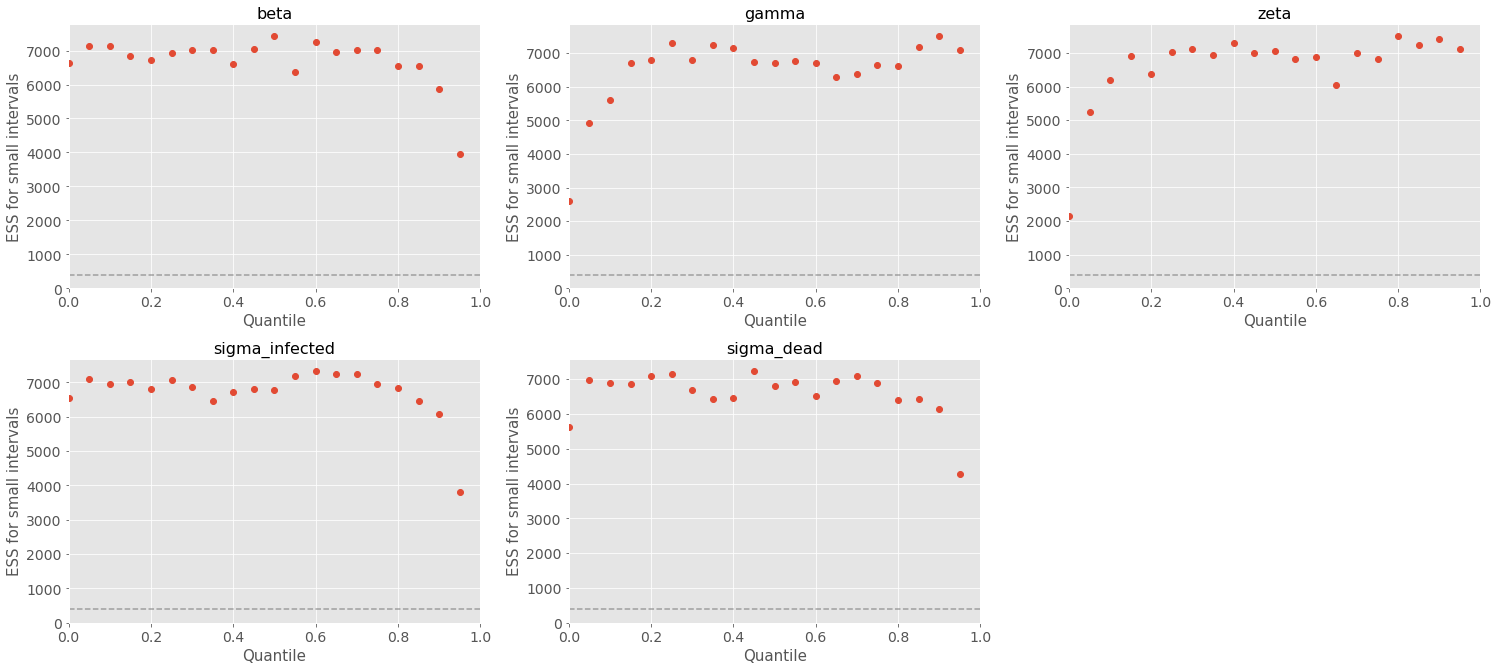

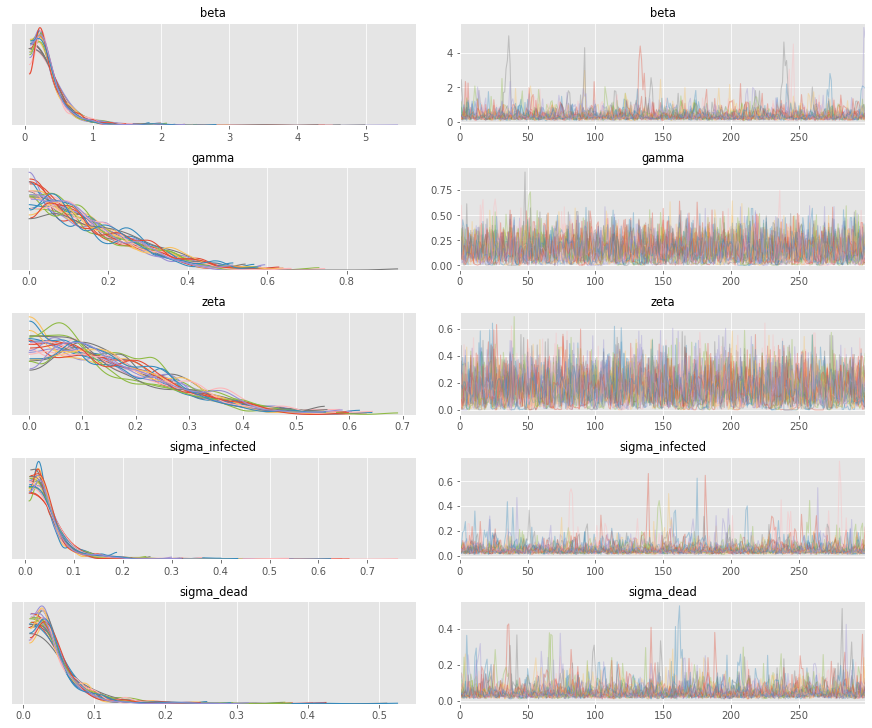

In [150]:
samples.param_validate_arviz(inferred, analysis_variables)

# Inference on simulated data

This is the real test.

In [151]:
sim_fit_model = cmdstanpy.CmdStanModel(stan_file='sird_reduced.stan')

sim_fit = sim_fit_model.sample(data=prior_data,
                               show_progress='notebook',
                               # Use a fixed seed so that our runs are deterministic.
                               seed=2222,
                               # This computer has 24 cores/48 threads; 24 chains is plenty
                               cores=24,
                               chains=24,
                               # Make the sampler a bit more robust in exchange for more sampling time
                               # adapt_delta=0.9,
                               # Let the sampler explore deeper
                               # max_treedepth=12,
                               # Make sure to get enough samples to avoid any diagnostic problems
                               iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(sim_fit, important_values)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced


INFO:cmdstanpy:Processing csv files: /tmp/tmpweompsv9/sird_reduced-202003231330-1-9udtkb2m.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-2-jyvg3g3o.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-3-4sutyeej.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-4-kxdwff6n.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-5-dgvxorim.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-6-uwiw22a6.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-7-8fv_oe51.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-8-6dxg1j6g.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-9-xfftnobo.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-10-mbuxow6g.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-11-2gcqrk3e.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-12-culx28ri.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-13-gtno7p8j.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-14-4jhw_jbf.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-15-eeb3cheq.csv, /tmp/tmpweompsv9/sird_reduced-202003231330-16-35r_lu0_.csv, /tmp/tmpweom

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-745.907000,0.035182,1.688540,-749.219000,-745.553000,-743.858000,2303.52,200.542,1.00946
beta,0.118631,0.000092,0.003147,0.114191,0.118221,0.124484,1169.90,101.850,1.02027
gamma,0.012226,0.000052,0.001839,0.009144,0.012247,0.015221,1261.01,109.782,1.01957
zeta,0.003273,0.000014,0.000513,0.002407,0.003276,0.004109,1257.49,109.475,1.02034
sigma_infected,1.850990,0.013096,0.475325,1.109030,1.823330,2.669250,1317.40,114.691,1.01609
sigma_dead,0.287518,0.000858,0.032469,0.241920,0.283658,0.346515,1430.84,124.567,1.01837


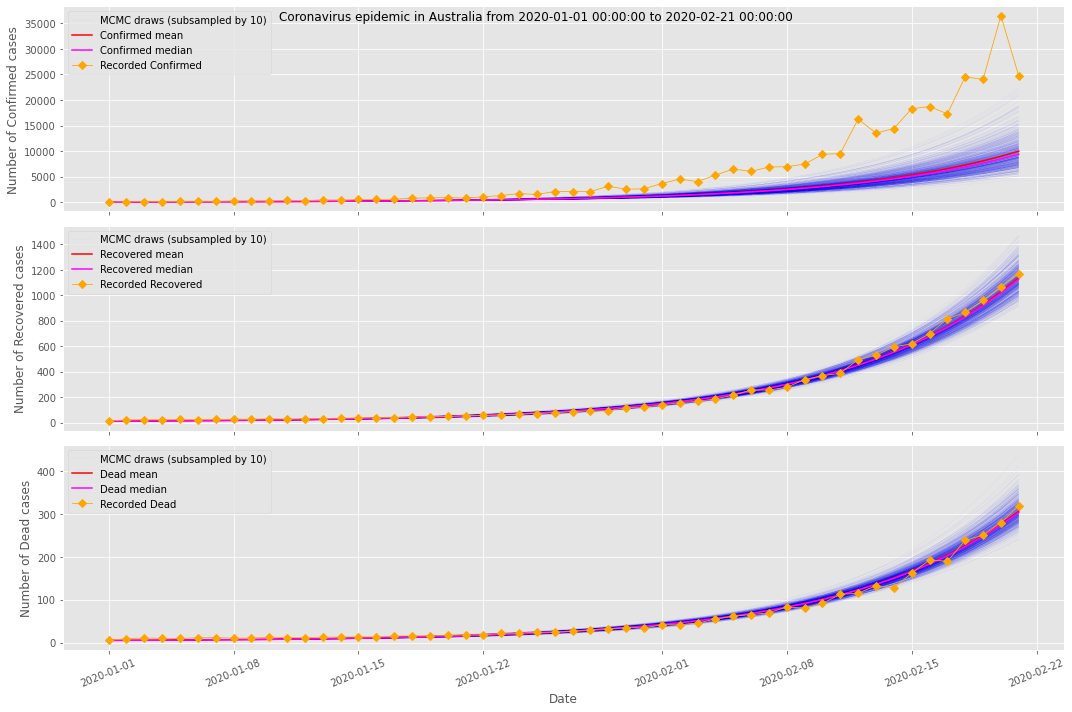

In [152]:
sim_fit_samples = samples.get_sample_time_series(sim_fit)
plot_posterior_time_series(sim_fit_samples, sim_comparison, sim_config)

In [153]:
sim_fit_summary = sim_fit.summary()
print("Errors in inference from simulated data:")
errors = pd.DataFrame(([sim_data[varname],
                        sim_fit_summary.loc[varname, 'Mean'],
                        np.abs(sim_data[varname] - sim_fit_summary.loc[varname, 'Mean'])]
                       for varname in analysis_variables),
                      columns=['Simulated value', 'Posterior mean', 'Error'],
                      index=analysis_variables)
print(errors)

Errors in inference from simulated data:
                Simulated value  Posterior mean     Error
beta                      0.120        0.118631  0.001369
gamma                     0.004        0.012226  0.008226
zeta                      0.001        0.003273  0.002273
sigma_infected            0.300        1.850990  1.550990
sigma_dead                0.100        0.287518  0.187518


#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

Displaying posterior plots.


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


Validating inference run.
LOO analysis:
 Computed from 7200 by 156 log-likelihood matrix

         Estimate       SE
elpd_loo  -883.05    31.27
p_loo        5.21        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      156  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Validating parameter sampling.


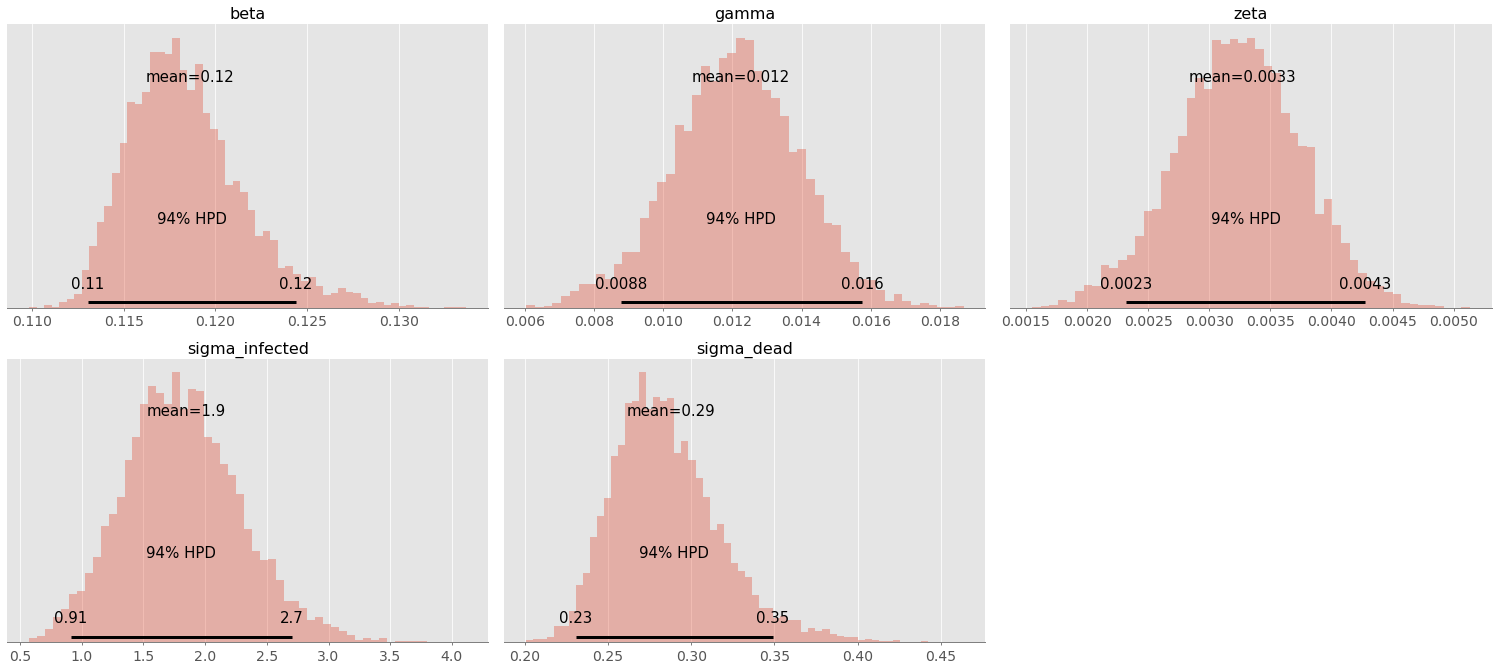

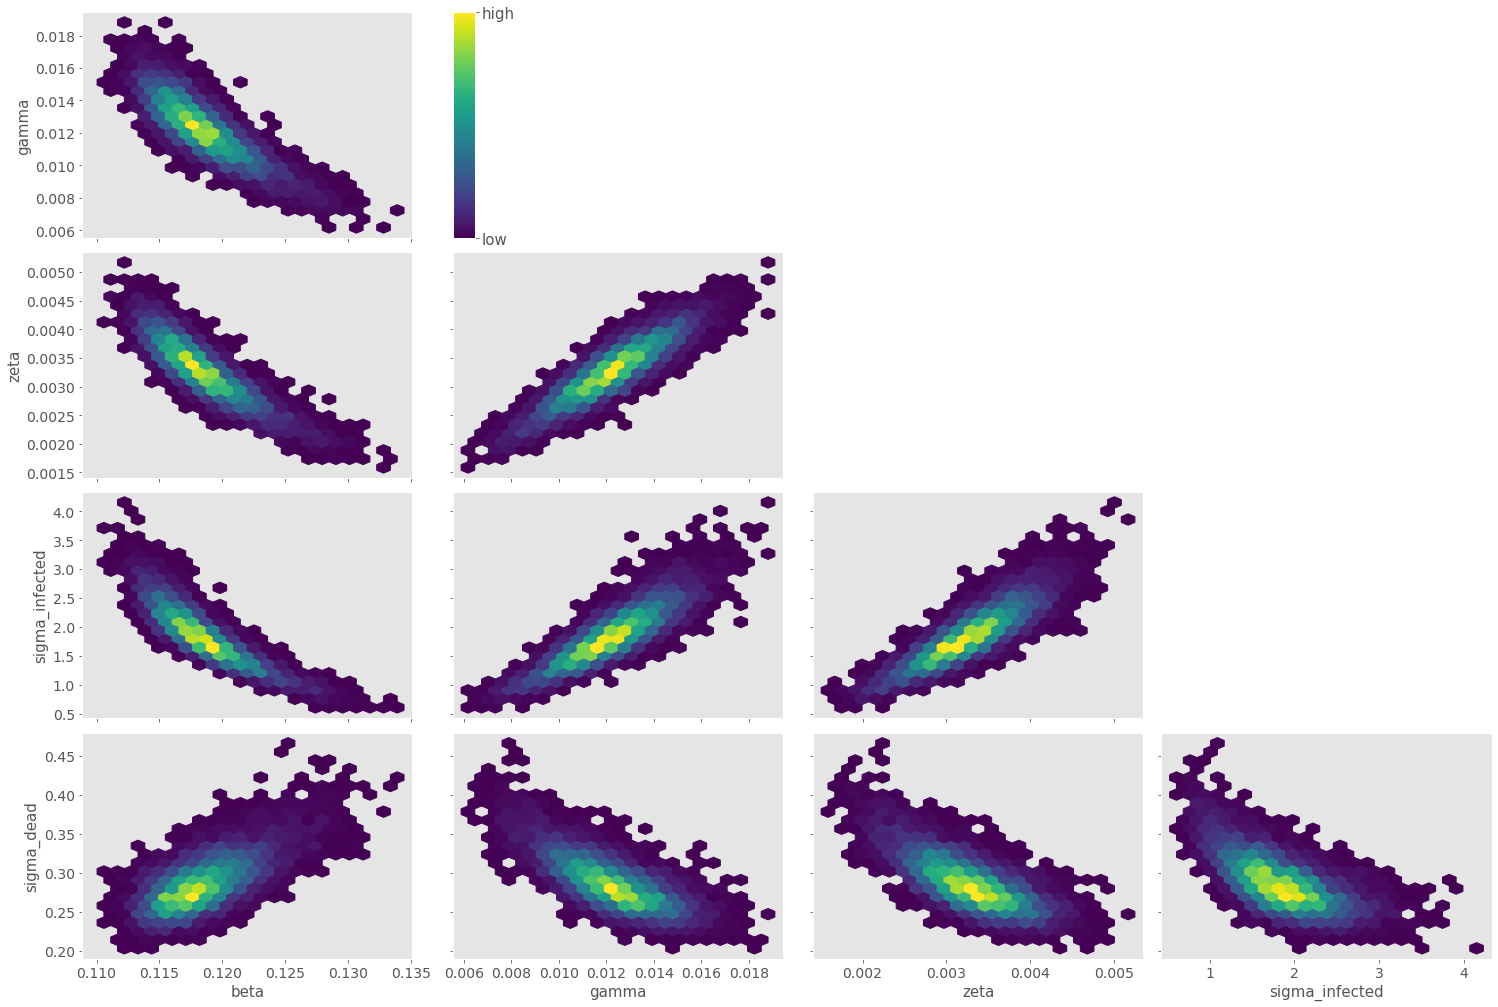

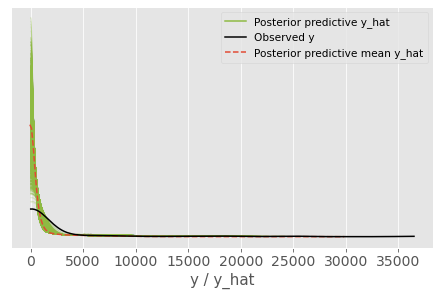

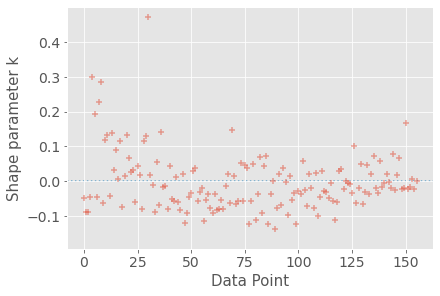

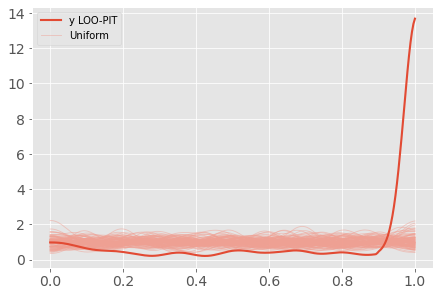

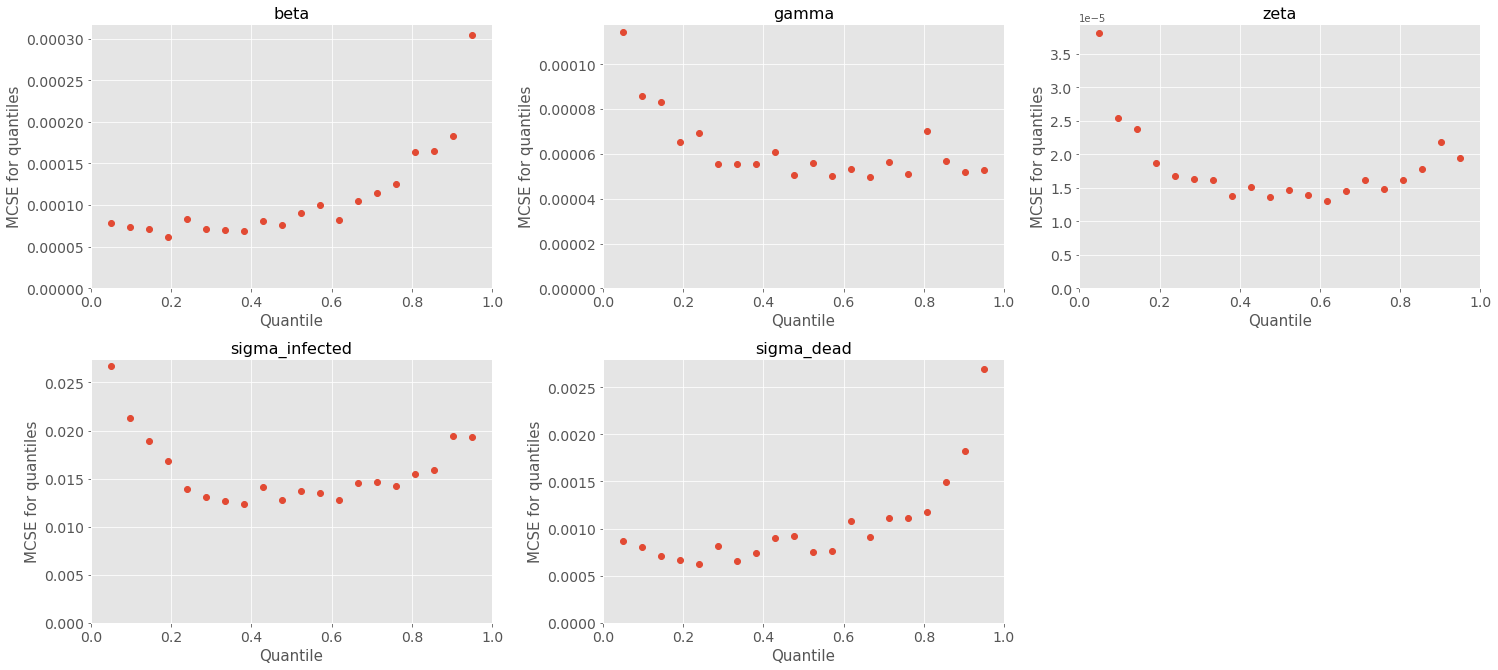

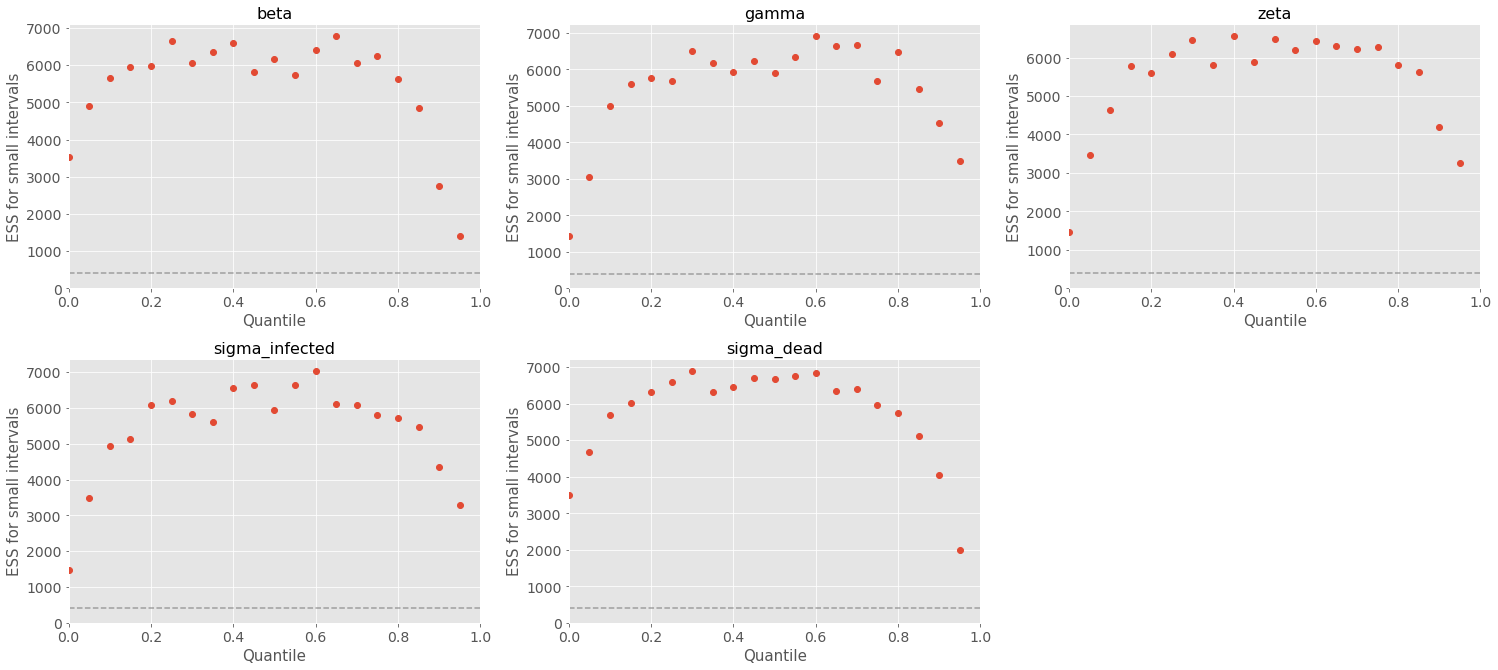

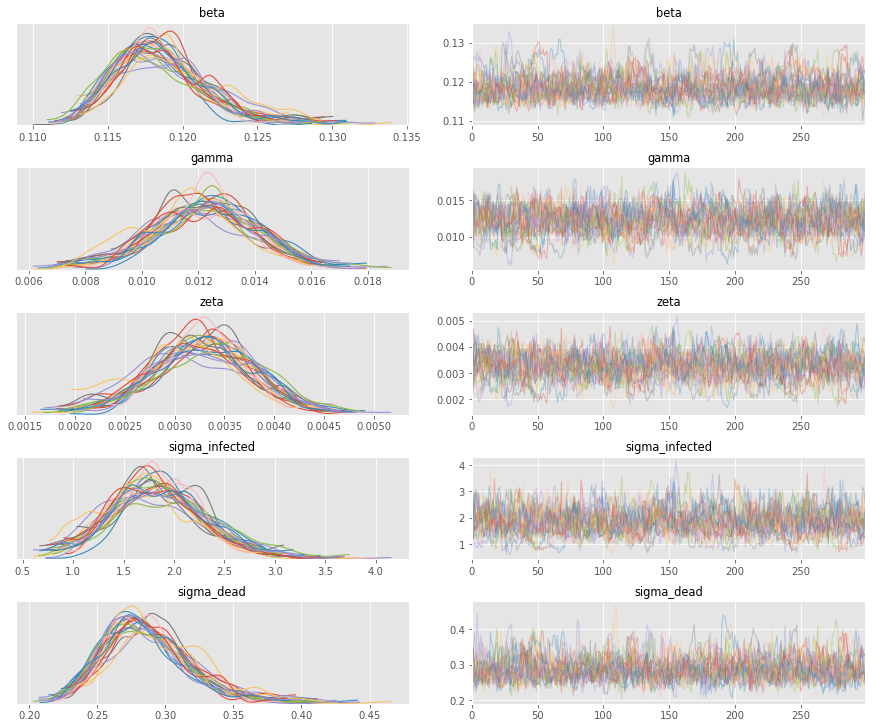

In [154]:
samples.standard_validate_arviz(sim_fit, 'log_likelihood', 'y_hat', sim_comparison.to_numpy(), analysis_variables)

# Inference from data

## Fetch the latest data on the epidemic

In [21]:
curl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
durl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
rurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

confirmed = pd.read_csv(curl, error_bad_lines=False)
dead = pd.read_csv(durl, error_bad_lines=False)
recovered = pd.read_csv(rurl, error_bad_lines=False)

data_start_index = '1/22/20'

Let's check out some of the earliest data sets.

In [22]:
def subset_country_names(table, countries):
    rose = []
    for country in countries:
        rose.append(confirmed[confirmed['Country/Region'] == country])
    return pd.concat(rose, axis=0)

subset_country_names(confirmed, ['Italy', 'Spain', 'Korea, South', 'Iran'])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
16,NaN,Italy,43.0,12.0,0,0,0,0,0,0,...,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578
18,NaN,Spain,40.0,-4.0,0,0,0,0,0,0,...,2277,5232,6391,7798,9942,11748,13910,17963,20410,25374
156,NaN,"Korea, South",36.0,128.0,1,1,2,2,3,4,...,7869,7979,8086,8162,8236,8320,8413,8565,8652,8799
155,NaN,Iran,32.0,53.0,0,0,0,0,0,0,...,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610


Configure the observations

In [23]:
data_config = {
    'start_index':data_start_index,
    'start_at_infections':50,
    'start_at_deaths':5,
    'country':'Australia',
    'model_file':'sird_reduced.stan',
}

## Extracting the time-series values

Here we'll pull out just the measurements we have for the specified country and organize them as a single matrix to feed into Stan.

In [24]:
measurements = form_table(data_config, confirmed, recovered, dead)
day_count = measurements.shape[0]
measurements.iloc[0, :]

Australia reached 50 "Confirmed" on 3/4/20; dropping preceding data


Confirmed    52
Recovered    11
Dead          2
Name: 3/4/20, dtype: int64

It's always a good idea to take a look at the data we plan to fit to.

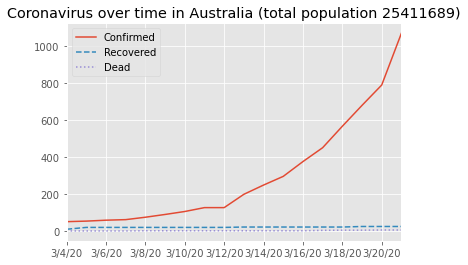

In [25]:
display_measurements(measurements, populations, data_config['country'])

If you plot an early country, you can clearly see the point at which the behavior change caused an inflection point in infections.

In [72]:
fit_data = {**prior_data, **{
    ## Parameters
    'y':measurements.to_numpy(),
    'T':day_count,
    'ts':list(range(0, day_count)),
    'population':populations[data_config['country']],
}}

In [27]:
fit_model = cmdstanpy.CmdStanModel(stan_file=data_config['model_file'])

fit = fit_model.sample(data=fit_data,
                               show_progress='notebook',
                               # Use a fixed seed so that our runs are deterministic.
                               seed=2222,
                               # This computer has 24 cores/48 threads; 24 chains is plenty
                               cores=24,
                               chains=24,
                               # Make the sampler a bit more robust in exchange for more sampling time
                               adapt_delta=0.9,
                               # Let the sampler explore deeper
                               # max_treedepth=12,
                               # Make sure to get enough samples to avoid any diagnostic problems
                               iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(fit, important_values)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced


KeyboardInterrupt: 

In [ ]:
fit_samples = samples.get_sample_time_series(fit)
plot_posterior_time_series(fit_samples, measurements, data_config)

#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

In [ ]:
samples.standard_validate_arviz(sim_fit, 'log_likelihood', 'y_hat', measurements.to_numpy, analysis_variables)